In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
from numpy import genfromtxt
from scipy import signal
from diff_tvr import *
from scipy import linalg as la
from scipy.optimize import minimize, fmin

In [2]:
force_actual = genfromtxt('./data/student_1_force_1.csv', delimiter=',')
strain_actual = genfromtxt('./data/student_1_strain_1.csv', delimiter=',')

In [3]:
def knife(state,u,dt):
    A = np.array([[0,1],[0,0]])
    B = np.array([0,1])
    return state + np.matmul(A,state)*dt + B*u*dt

def ref_dynamics(dt):
    A = np.array([[1,dt],[0,1]])
    B = np.array([0,dt])
    return A, B

def get_closest_point(traj,x):
    dists = np.sqrt(np.sum((traj - x)**2,axis=1))
    idx = np.argmin(dists)
    return idx

def v2f(state,u,dt):
    new_state = state -4*state*dt + u*dt
    return new_state

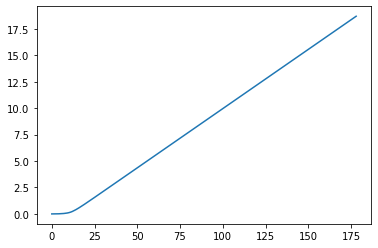

In [28]:
# Strain reference (linear model)

strain_ref = np.array([8.13151629e-19, 9.33483785e-04, 2.89652966e-03, 6.09118303e-03,
       1.08462518e-02, 1.76511489e-02, 2.72062646e-02, 4.04950538e-02,
       5.88852578e-02, 8.42696784e-02, 1.19260993e-01, 1.67460663e-01,
       2.30965552e-01, 3.07703418e-01, 3.94067421e-01, 4.87425222e-01,
       5.85864316e-01, 6.87995184e-01, 7.92808283e-01, 8.99570138e-01,
       1.00774785e+00, 1.11695423e+00, 1.22690800e+00, 1.33740476e+00,
       1.44829604e+00, 1.55947395e+00, 1.67086011e+00, 1.78239758e+00,
       1.89404497e+00, 2.00577223e+00, 2.11755751e+00, 2.22938495e+00,
       2.34124303e+00, 2.45312336e+00, 2.56501985e+00, 2.67692810e+00,
       2.78884488e+00, 2.90076786e+00, 3.01269534e+00, 3.12462610e+00,
       3.23655923e+00, 3.34849410e+00, 3.46043022e+00, 3.57236725e+00,
       3.68430494e+00, 3.79624312e+00, 3.90818164e+00, 4.02012042e+00,
       4.13205939e+00, 4.24399849e+00, 4.35593768e+00, 4.46787695e+00,
       4.57981627e+00, 4.69175562e+00, 4.80369501e+00, 4.91563441e+00,
       5.02757382e+00, 5.13951325e+00, 5.25145269e+00, 5.36339213e+00,
       5.47533157e+00, 5.58727102e+00, 5.69921047e+00, 5.81114992e+00,
       5.92308937e+00, 6.03502882e+00, 6.14696827e+00, 6.25890773e+00,
       6.37084718e+00, 6.48278664e+00, 6.59472609e+00, 6.70666555e+00,
       6.81860500e+00, 6.93054445e+00, 7.04248391e+00, 7.15442336e+00,
       7.26636282e+00, 7.37830227e+00, 7.49024173e+00, 7.60218118e+00,
       7.71412064e+00, 7.82606009e+00, 7.93799955e+00, 8.04993900e+00,
       8.16187846e+00, 8.27381791e+00, 8.38575737e+00, 8.49769682e+00,
       8.60963628e+00, 8.72157573e+00, 8.83351518e+00, 8.94545464e+00,
       9.05739409e+00, 9.16933355e+00, 9.28127300e+00, 9.39321246e+00,
       9.50515191e+00, 9.61709137e+00, 9.72903082e+00, 9.84097028e+00,
       9.95290973e+00, 1.00648492e+01, 1.01767886e+01, 1.02887281e+01,
       1.04006676e+01, 1.05126070e+01, 1.06245465e+01, 1.07364859e+01,
       1.08484254e+01, 1.09603648e+01, 1.10723043e+01, 1.11842437e+01,
       1.12961832e+01, 1.14081226e+01, 1.15200621e+01, 1.16320016e+01,
       1.17439410e+01, 1.18558805e+01, 1.19678199e+01, 1.20797594e+01,
       1.21916988e+01, 1.23036383e+01, 1.24155777e+01, 1.25275172e+01,
       1.26394566e+01, 1.27513961e+01, 1.28633356e+01, 1.29752750e+01,
       1.30872145e+01, 1.31991539e+01, 1.33110934e+01, 1.34230328e+01,
       1.35349723e+01, 1.36469117e+01, 1.37588512e+01, 1.38707906e+01,
       1.39827301e+01, 1.40946696e+01, 1.42066090e+01, 1.43185485e+01,
       1.44304879e+01, 1.45424274e+01, 1.46543668e+01, 1.47663063e+01,
       1.48782457e+01, 1.49901852e+01, 1.51021247e+01, 1.52140641e+01,
       1.53260036e+01, 1.54379430e+01, 1.55498825e+01, 1.56618219e+01,
       1.57737614e+01, 1.58857008e+01, 1.59976403e+01, 1.61095797e+01,
       1.62215192e+01, 1.63334587e+01, 1.64453981e+01, 1.65573376e+01,
       1.66692770e+01, 1.67812165e+01, 1.68931559e+01, 1.70050954e+01,
       1.71170348e+01, 1.72289743e+01, 1.73409137e+01, 1.74528532e+01,
       1.75647927e+01, 1.76767321e+01, 1.77886716e+01, 1.79006110e+01,
       1.80125505e+01, 1.81244899e+01, 1.82364294e+01, 1.83483688e+01,
       1.84603083e+01, 1.85722477e+01, 1.86841872e+01])

plt.plot(strain_ref)

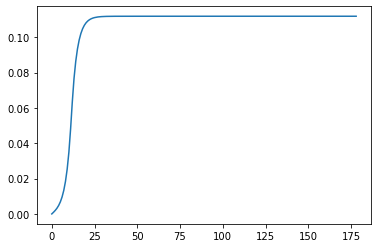

In [29]:
dstrain_ref = np.array([8.13151629e-19, 9.33483785e-04, 1.96304587e-03, 3.19465337e-03,
       4.75506881e-03, 6.80489709e-03, 9.55511564e-03, 1.32887892e-02,
       1.83902041e-02, 2.53844205e-02, 3.49913145e-02, 4.81996702e-02,
       6.35048893e-02, 7.67378655e-02, 8.63640031e-02, 9.33578014e-02,
       9.84390934e-02, 1.02130868e-01, 1.04813099e-01, 1.06761855e-01,
       1.08177708e-01, 1.09206386e-01, 1.09953764e-01, 1.10496766e-01,
       1.10891280e-01, 1.11177911e-01, 1.11386161e-01, 1.11537463e-01,
       1.11647391e-01, 1.11727258e-01, 1.11785285e-01, 1.11827444e-01,
       1.11858074e-01, 1.11880328e-01, 1.11896497e-01, 1.11908244e-01,
       1.11916779e-01, 1.11922980e-01, 1.11927485e-01, 1.11930758e-01,
       1.11933136e-01, 1.11934864e-01, 1.11936119e-01, 1.11937032e-01,
       1.11937694e-01, 1.11938176e-01, 1.11938525e-01, 1.11938780e-01,
       1.11938964e-01, 1.11939098e-01, 1.11939196e-01, 1.11939267e-01,
       1.11939318e-01, 1.11939355e-01, 1.11939383e-01, 1.11939402e-01,
       1.11939417e-01, 1.11939427e-01, 1.11939435e-01, 1.11939440e-01,
       1.11939444e-01, 1.11939447e-01, 1.11939449e-01, 1.11939451e-01,
       1.11939452e-01, 1.11939453e-01, 1.11939453e-01, 1.11939454e-01,
       1.11939454e-01, 1.11939454e-01, 1.11939454e-01, 1.11939454e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01, 1.11939455e-01,
       1.11939455e-01, 1.11939455e-01, 1.11939455e-01])

plt.plot(dstrain_ref)

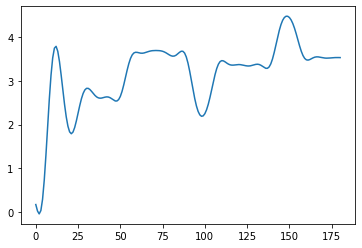

In [6]:
# Strain rate

dstrain_actual = np.array([ 0.17456395,  0.02892607, -0.03928913,  0.03707098,  0.294503  ,
        0.73090059,  1.30606374,  1.95096986,  2.58361671,  3.12694022,
        3.52359512,  3.74393536,  3.78646747,  3.67266636,  3.43918023,
        3.13005448,  2.79037235,  2.46152342,  2.17776658,  1.96386553,
        1.83386213,  1.7910726 ,  1.82914695,  1.93384226,  2.08522622,
        2.26023917,  2.43562784,  2.59105369,  2.7118133 ,  2.79045298,
        2.82684157,  2.82682009,  2.80000517,  2.75745493,  2.70973314,
        2.66559571,  2.63125153,  2.61003089,  2.60233205,  2.60582384,
        2.61595718,  2.6268405 ,  2.63247145,  2.62821482,  2.61229393,
        2.58695219,  2.5588908 ,  2.53864848,  2.53879025,  2.57110033,
        2.64335818,  2.75658771,  2.90375019,  3.07056984,  3.2385229 ,
        3.38919167,  3.50858591,  3.59002085,  3.63474123,  3.65035521,
        3.64786275,  3.63837397,  3.63050077,  3.62900554,  3.63479945,
        3.64597147,  3.65930395,  3.67171447,  3.68121303,  3.68719802,
        3.69015201,  3.69097283,  3.69025444,  3.68780861,  3.68261226,
        3.67321063,  3.65844797,  3.63827918,  3.6143721 ,  3.59024915,
        3.57082111,  3.56130514,  3.56567364,  3.58494043,  3.61572986,
        3.6496401 ,  3.67384201,  3.67310866,  3.63306658,  3.54398532,
        3.40403712,  3.22085738,  3.01059158,  2.79445106,  2.59384954,
        2.42589493,  2.300866  ,  2.22232936,  2.18931878,  2.19917105,
        2.24952463,  2.33857292,  2.46361049,  2.61881004,  2.79363406,
        2.97306719,  3.13998287,  3.27885299,  3.37931924,  3.43826399,
        3.45977363,  3.4532553 ,  3.43053488,  3.4029079 ,  3.37892091,
        3.36328588,  3.35693476,  3.35792416,  3.36276021,  3.3677296 ,
        3.36994294,  3.36794866,  3.36190247,  3.35335417,  3.34474784,
        3.33874352,  3.33747665,  3.3418842 ,  3.35124121,  3.3630532 ,
        3.37342029,  3.3779118 ,  3.37286474,  3.35686573,  3.3320367 ,
        3.3046758 ,  3.28486129,  3.28483553,  3.31633108,  3.38740445,
        3.49967353,  3.64695058,  3.81598095,  3.98931099,  4.14942233,
        4.28263929,  4.38137408,  4.44404816,  4.47307764,  4.47207953,
        4.443638  ,  4.38857843,  4.30695083,  4.20013002,  4.07290549,
        3.93439107,  3.79709849,  3.67438761,  3.57728576,  3.5119245 ,
        3.47847774,  3.47179519,  3.48330512,  3.50344122,  3.52384813,
        3.53884286,  3.54592527,  3.54542759,  3.53959304,  3.53144878,
        3.52380084,  3.51856575,  3.5165147 ,  3.517383  ,  3.52021778,
        3.52381007,  3.52707667,  3.52930569,  3.53023803,  3.5300072 ,
        3.52899174])

plt.plot(dstrain_actual)

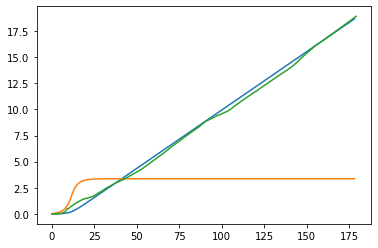

In [32]:
# Trajectory

x_traj = np.vstack((strain_ref,dstrain_ref/dt)).T
plt.plot(x_traj)
plt.plot(strain_actual)
plt.show()

### Constant strain rate model, no disturbance

KeyboardInterrupt: 

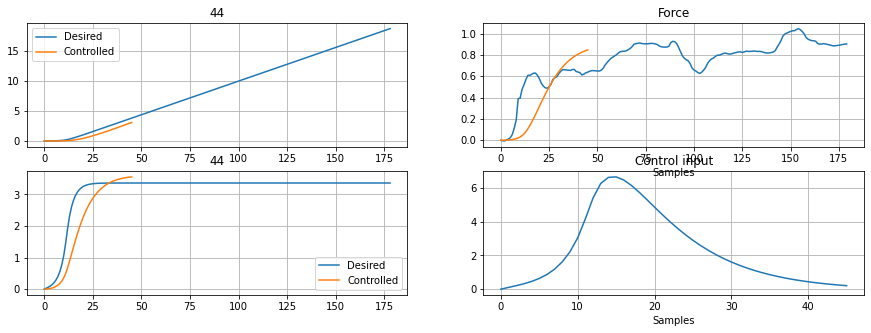

In [38]:
plt.figure(figsize=(15,5))

states = [np.zeros(2)]
controls = [0]
force = [0]

lookahead = 1
dt = 0.0333 

Q = np.eye(2); Q[0,0] = 0.1;
R = 0.01

Nsteps = 180

idx = 0

for j in range(Nsteps-2):
    # Find closest reference point in front of knife
    idx = min(idx+get_closest_point(x_traj[idx:,0:2],states[-1][0:2])+lookahead,x_traj.shape[0]-1)

    A,B = ref_dynamics(dt=dt)

    # Ricatti 
    P = la.solve_discrete_are(A, B.reshape(2,1), Q, R)
    K = np.matmul((1.0/R)*B.T,P)

    path_err = states[j] - x_traj[idx,:]

    u = np.matmul(-K,path_err)
    
    states.append(knife(states[-1],u,dt))
    controls.append(u)
    force.append(v2f(force[-1],states[-1][1],dt))

    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(x_traj[:,0],label='Desired')
    plt.plot(np.array(states)[:,0],label='Controlled')
    plt.legend()
    plt.title(j)
    plt.grid()
    
    plt.subplot(2,2,3)
    plt.plot(x_traj[:,1],label='Desired')
    plt.plot(np.array(states)[:,1],label='Controlled')
    plt.legend()
    plt.title(j)
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(np.array(controls))
    plt.xlabel('Samples')
    plt.title('Control input')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.array(force_actual))
    plt.plot(np.array(force))
    plt.xlabel('Samples')
    plt.title('Force')
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [34]:
def generative_controller_model(x_traj,sigQ1,sigQ2,sigR):
    
    states = [np.zeros(2)]
    controls = [0]
    force = [0]
    
    Q = np.eye(2); Q[0,0] = sigQ1**2; Q[1,1] = sigQ2**2
    R = sigR**2

    idx = 0

    for j in range(Nsteps-1):
        
        idx = min(idx+get_closest_point(x_traj[idx:,0:2],states[-1][0:2])+lookahead,x_traj.shape[0]-1)
        A,B = ref_dynamics(dt=dt)

        # Ricatti 
        P = la.solve_discrete_are(A, B.reshape(2,1), Q, R)
        K = np.matmul((1.0/R)*B.T,P)

        path_err = states[j] - x_traj[idx,:]

        u = np.matmul(-K,path_err)

        states.append(knife(states[-1],u,dt))
        controls.append(u)
        force.append(v2f(force[-1],states[-1][1],dt))
        
    return np.array(force)

In [35]:
def cost(X):
    force_gen = generative_controller_model(x_traj,X[0],X[1],X[2])
    c = np.sum((np.array(force_actual)-np.array(force_gen))**2)
    return c

In [36]:
params = np.abs(fmin(cost,np.array([0.1,0.1,0.01]),xtol=1e-12,maxiter=1e5,ftol=1e-12))
print(params)

Optimization terminated successfully.
         Current function value: 3.001485
         Iterations: 215
         Function evaluations: 417
[0.09842458 0.12960713 0.00549995]


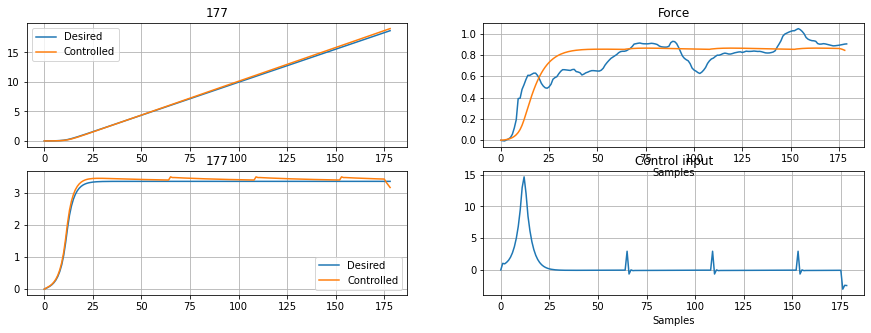

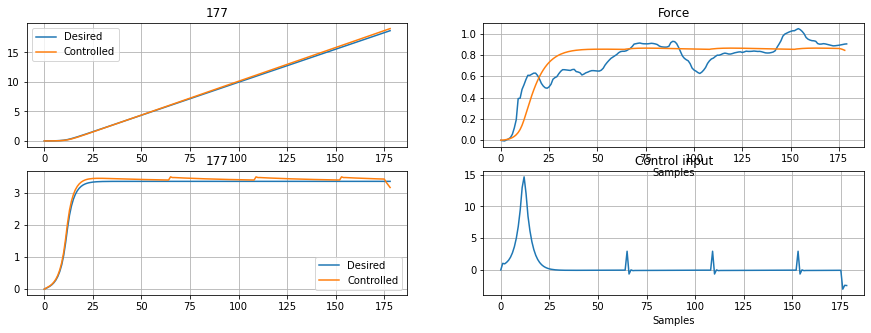

In [41]:
plt.figure(figsize=(15,5))

states = [np.zeros(2)]
controls = [0]
force = [0]

lookahead = 1
dt = 0.0333

Q = np.eye(2); Q[0,0] = params[0]**2; Q[1,1] = params[1]**2
R = params[2]**2

Nsteps = 180

idx = 0

for j in range(Nsteps-2):
    # Find closest reference point in front of knife
    idx = min(idx+get_closest_point(x_traj[idx:,0:2],states[-1][0:2])+lookahead,x_traj.shape[0]-1)

    A,B = ref_dynamics(dt=dt)

    # Ricatti 
    P = la.solve_discrete_are(A, B.reshape(2,1), Q, R)
    K = np.matmul((1.0/R)*B.T,P)

    path_err = states[j] - x_traj[idx,:]

    u = np.matmul(-K,path_err)
    
    states.append(knife(states[-1],u,dt))
    controls.append(u)
    force.append(v2f(force[-1],states[-1][1],dt))

    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(x_traj[:,0],label='Desired')
    plt.plot(np.array(states)[:,0],label='Controlled')
    plt.legend()
    plt.title(j)
    plt.grid()
    
    plt.subplot(2,2,3)
    plt.plot(x_traj[:,1],label='Desired')
    plt.plot(np.array(states)[:,1],label='Controlled')
    plt.legend()
    plt.title(j)
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(np.array(controls))
    plt.xlabel('Samples')
    plt.title('Control input')
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.array(force_actual))
    plt.plot(np.array(force))
    plt.xlabel('Samples')
    plt.title('Force')
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())

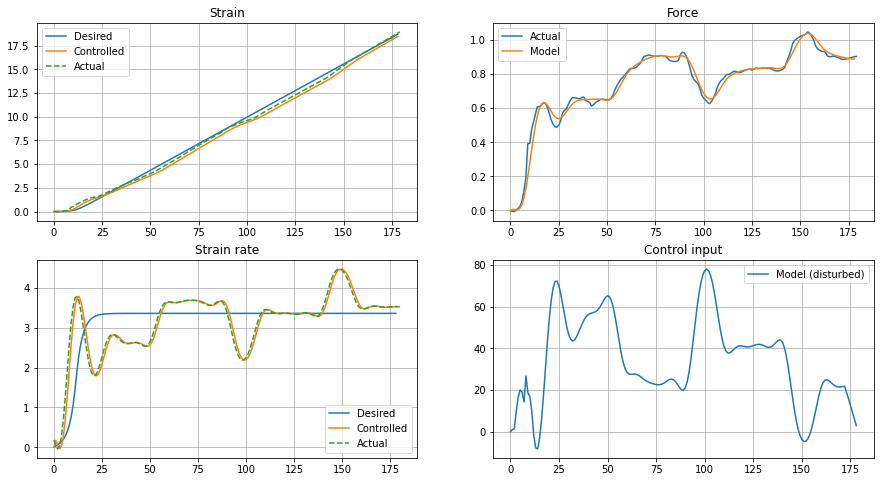

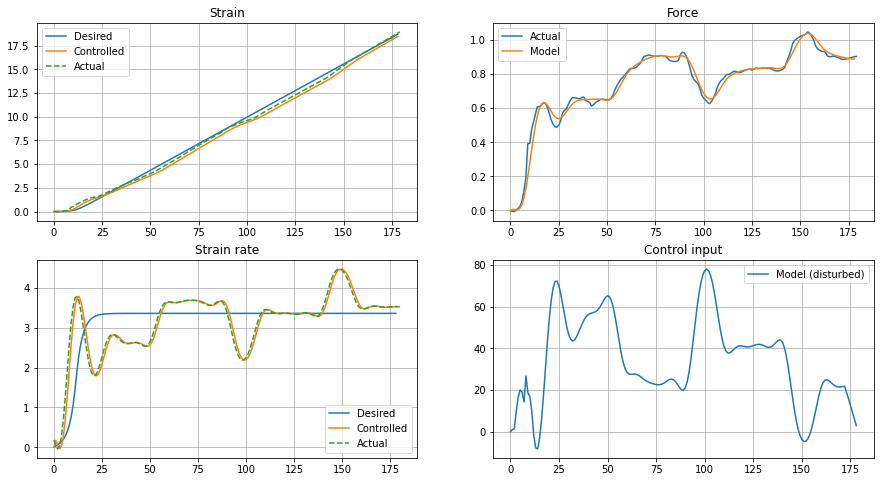

In [40]:
plt.figure(figsize=(15,8))

states = [np.zeros(2)]
controls = [0]
force = [0]
d = np.zeros(strain_ref.shape[0]) # disturbance

lookahead = 1
dt = 0.0333 

Q = np.eye(2); Q[0,0] = params[0]**2; Q[1,1] = params[1]**2
R = params[2]**2

Nsteps = 180

idx = 0

for j in range(Nsteps-2):
    # Find closest reference point in front of knife
    idx = min(idx+get_closest_point(x_traj[idx:,0:2],states[-1][0:2])+lookahead,x_traj.shape[0]-1)

    A,B = ref_dynamics(dt=dt)

    # Ricatti 
    P = la.solve_discrete_are(A, B.reshape(2,1), Q, R)
    K = np.matmul((1.0/R)*B.T,P)

    path_err = states[j] - x_traj[idx,:]

    u = np.matmul(-K,path_err)
    
    d[j] = dstrain_actual[j] - knife(states[-1],u,dt)[1]
    states.append(knife(states[-1],u+d[j]/dt,dt))
    
    controls.append(u)
    force.append(v2f(force[-1],states[-1][1],dt))

    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(x_traj[:,0],label='Desired')
    plt.plot(np.array(states)[:,0],label='Controlled')
    plt.plot(strain_actual,'--',label='Actual')
    plt.legend()
    plt.title('Strain')
    plt.grid()
    
    plt.subplot(2,2,3)
    plt.plot(x_traj[:,1],label='Desired')
    plt.plot(np.array(states)[:,1],label='Controlled')
    plt.plot(dstrain_actual,'--',label='Actual')
    plt.legend()
    plt.title('Strain rate')
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(np.array(controls),label='Model (disturbed)')
    plt.title('Control input')
    plt.legend()
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.array(force_actual),label='Actual')
    plt.plot(np.array(force),label='Model')
    plt.title('Force')
    plt.legend()
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())

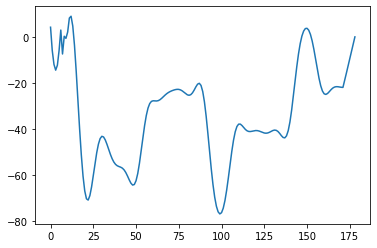

In [45]:
plt.plot(d/dt)

### Constant strain rate model + disturbance

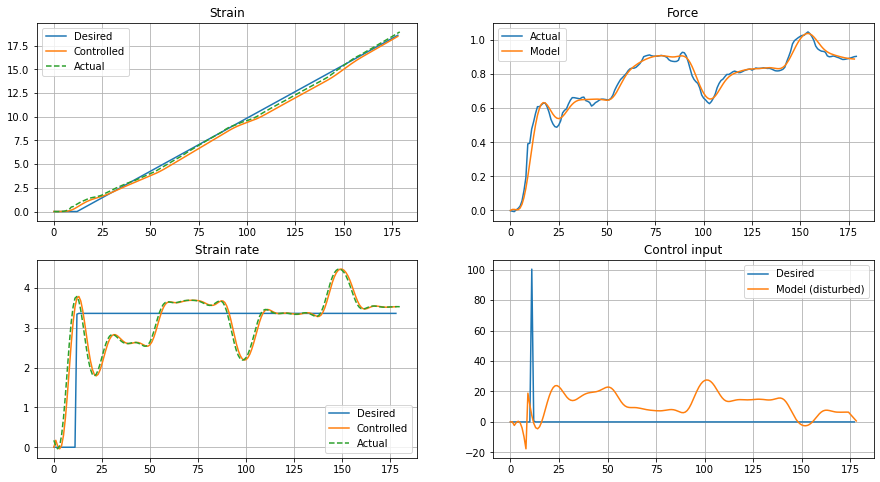

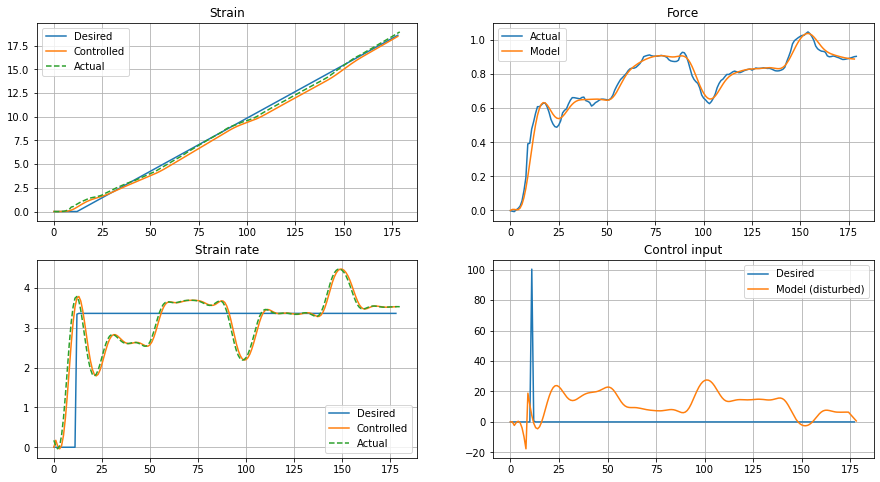

In [25]:
plt.figure(figsize=(15,8))

states = [np.zeros(2)]
controls = [0]
force = [0]
d = np.zeros(strain_ref.shape[0]) # disturbance

lookahead = 1
dt = 0.0333 

Q = np.eye(2); #Q[1,1] = 10;
R = 0.01

Nsteps = 180

idx = 0

for j in range(Nsteps-2):
    # Find closest reference point in front of knife
    idx = min(idx+get_closest_point(x_traj[idx:,0:2],states[-1][0:2])+lookahead,x_traj.shape[0]-1)

    A,B = ref_dynamics(dt=dt)

    # Ricatti 
    P = la.solve_discrete_are(A, B.reshape(2,1), Q, R)
    K = np.matmul((1.0/R)*B.T,P)

    path_err = states[j] - x_traj[idx,:]

    u = np.matmul(-K,path_err)
    
    d[j] = dstrain_actual[j] - knife(states[-1],u,dt)[1]
    states.append(knife(states[-1],u+d[j]/dt,dt))
    
    controls.append(u)
    force.append(v2f(force[-1],states[-1][1],dt))

    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(x_traj[:,0],label='Desired')
    plt.plot(np.array(states)[:,0],label='Controlled')
    plt.plot(strain_actual,'--',label='Actual')
    plt.legend()
    plt.title('Strain')
    plt.grid()
    
    plt.subplot(2,2,3)
    plt.plot(x_traj[:,1],label='Desired')
    plt.plot(np.array(states)[:,1],label='Controlled')
    plt.plot(dstrain_actual,'--',label='Actual')
    plt.legend()
    plt.title('Strain rate')
    plt.grid()

    plt.subplot(2,2,4)
    plt.plot(np.array(controls_ref),label='Desired')
    plt.plot(np.array(controls),label='Model (disturbed)')
    plt.title('Control input')
    plt.legend()
    plt.grid()
    
    plt.subplot(2,2,2)
    plt.plot(np.array(force_actual),label='Actual')
    plt.plot(np.array(force),label='Model')
    plt.title('Force')
    plt.legend()
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())

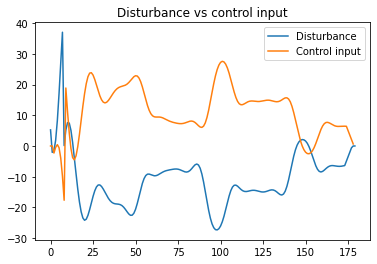

In [16]:
plt.plot(d/dt,label='Disturbance')
plt.plot(controls,label='Control input')
plt.title('Disturbance vs control input')
plt.legend()

### Pole placement feedback

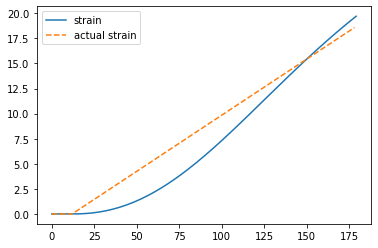

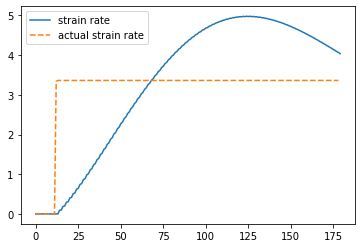

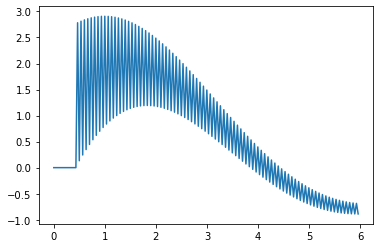

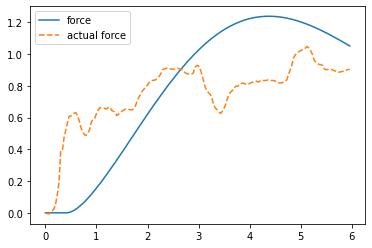

In [147]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

Kp = 24
Kd = 60
Ki = 1

states = [np.zeros(2)]
controls = [0]
force = [0]
error = [0]

for i in range(t.shape[0]-1):
    
    err = strain_ref[i] - states[-1][0]
    error.append(error[-1]+err)
    controls.append(Kp*err - Kd*states[-1][1] + Ki*error[-1])
    states.append(knife(states[-1],controls[-1],dt))
    force.append(v2f(force[-1],states[-1][1],dt))
    
plt.plot(np.array(states)[:,0],label='strain')
plt.plot(np.array(states_ref)[:,0],'--',label='actual strain')
plt.legend()
plt.show()

plt.plot(np.array(states)[:,1],label='strain rate')
plt.plot(np.array(states_ref)[:,1],'--',label='actual strain rate')
plt.legend()
plt.show()

plt.plot(t,np.array(controls))
plt.show()

plt.plot(t,force,label='force')
plt.plot(t,force_actual,'--',label='actual force')
plt.legend()

### PID inference

In [170]:
def PID_rollout(reference,Kp,Ki,Kd,dt):
    
    N = reference.shape[0]
    t = np.arange(0,N*dt,dt)

    states = [np.zeros(2)]
    controls = [0]
    force = [0]
    error = [0]

    for i in range(t.shape[0]-1):

        err = reference[i] - states[-1][0]
        error.append(error[-1]+err)
        controls.append(Kp*err - Kd*states[-1][1] + Ki*error[-1])
        states.append(knife(states[-1],controls[-1],dt))
        force.append(v2f(force[-1],states[-1][1],dt))
    
    return np.array(states)[:,0]

In [183]:
def cost(X):
    strain_gen = PID_rollout(strain_ref,X[0],X[1],X[2],dt)
    c = np.sum((np.array(strain_ref)-np.array(strain_gen))**2) + X[1]**2
    return c

In [162]:
from scipy.optimize import minimize, fmin 

In [184]:
params = np.abs(fmin(cost,5*np.ones(3),xtol=1e-12,maxiter=1e5,ftol=1e-12))
print(params)

Optimization terminated successfully.
         Current function value: 2.305623
         Iterations: 255
         Function evaluations: 534
[2.34648196e+03 7.70857067e-02 8.00713307e+01]


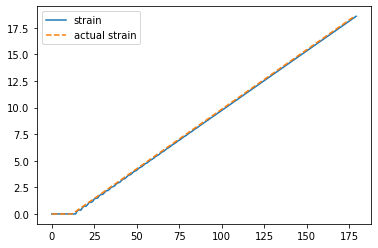

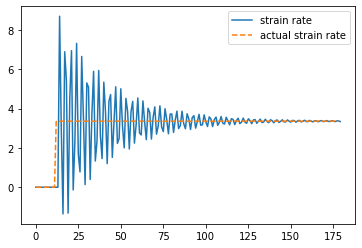

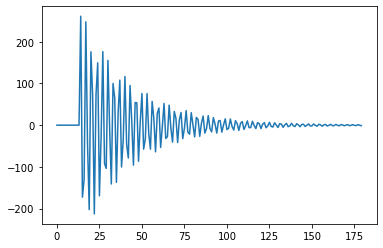

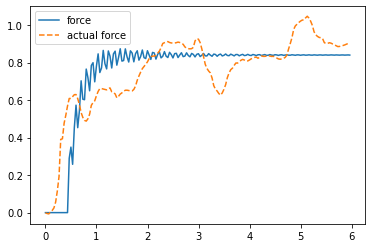

In [185]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

Kp = params[0]
Ki = params[1]
Kd = params[2]

states = [np.zeros(2)]
controls = [0]
force = [0]
error = [0]

for i in range(t.shape[0]-1):
    
    err = strain_ref[i] - states[-1][0]
    error.append(error[-1]+err)
    controls.append(Kp*err - Kd*states[-1][1] + Ki*error[-1])
    states.append(knife(states[-1],controls[-1],dt))
    force.append(v2f(force[-1],states[-1][1],dt))
    
plt.plot(np.array(states)[:,0],label='strain')
plt.plot(np.array(states_ref)[:,0],'--',label='actual strain')
plt.legend()
plt.show()

plt.plot(np.array(states)[:,1],label='strain rate')
plt.plot(np.array(states_ref)[:,1],'--',label='actual strain rate')
plt.legend()
plt.show()

plt.plot(np.array(controls))
plt.show()

plt.plot(t,force,label='force')
plt.plot(t,force_actual,'--',label='actual force')
plt.legend()

### ADRC

In [76]:
def observer(x,u,y,L,b0,dt):

    A = np.array([[-L[0],1,0],[-L[1],0,1],[-L[2],0,0]])
    B = np.array([0,b0,0])
    
    return x + np.matmul(A,x)*dt + B*u*dt + L*y*dt

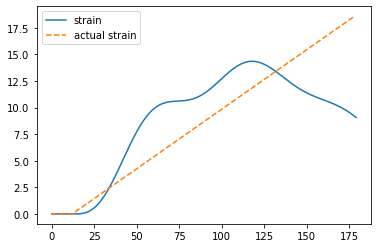

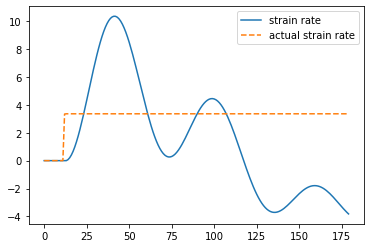

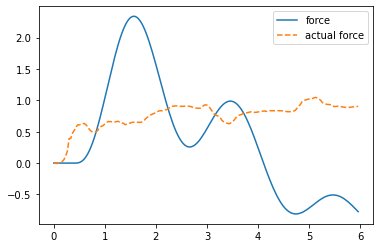

In [104]:
N = 180
dt = 0.0333
t = np.arange(0,N*dt,dt)

Kp = 10
Kd = 1
L = np.random.randn(3)
b0 = np.random.randn()

states = [np.zeros(2)] # true state
states_hat = [np.zeros(3)] # state estimate
controls = [0]
force = [0]

for i in range(t.shape[0]-1):
    
    states_hat.append(observer(states_hat[-1],controls[-1],states[-1][0],L,b0,dt))
    
    err = strain_ref[i] - states_hat[-1][0]
    u0 = Kp*err - Kd*states_hat[-1][1]
    controls.append((u0 - states_hat[-1][2])/b0)
    states.append(knife(states[-1],controls[-1],dt))
    force.append(v2f(force[-1],states[-1][1],dt))
    
plt.plot(np.array(states)[:,0],label='strain')
plt.plot(np.array(states_ref)[:,0],'--',label='actual strain')
plt.legend()
plt.show()

plt.plot(np.array(states)[:,1],label='strain rate')
plt.plot(np.array(states_ref)[:,1],'--',label='actual strain rate')
plt.legend()
plt.show()

plt.plot(t,force,label='force')
plt.plot(t,force_actual,'--',label='actual force')
plt.legend()

In [105]:
strain_ref

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.11130732,  0.22324677,
        0.33518623,  0.44712568,  0.55906513,  0.67100459,  0.78294404,
        0.8948835 ,  1.00682295,  1.11876241,  1.23070186,  1.34264132,
        1.45458077,  1.56652023,  1.67845968,  1.79039914,  1.90233859,
        2.01427805,  2.1262175 ,  2.23815696,  2.35009641,  2.46203587,
        2.57397532,  2.68591478,  2.79785423,  2.90979368,  3.02173314,
        3.13367259,  3.24561205,  3.3575515 ,  3.46949096,  3.58143041,
        3.69336987,  3.80530932,  3.91724878,  4.02918823,  4.14112769,
        4.25306714,  4.3650066 ,  4.47694605,  4.58888551,  4.70082496,
        4.81276442,  4.92470387,  5.03664333,  5.14858278,  5.26052223,
        5.37246169,  5.48440114,  5.5963406 ,  5.70828005,  5.82021951,
        5.93215896,  6.04409842,  6.15603787,  6.26797733,  6.37

In [106]:
strain_actual

array([-1.46149076e-03, -5.25616795e-03, -8.10699525e-03,  1.94726499e-03,
        1.13327621e-02,  2.68605076e-02,  6.31140385e-02,  1.34034839e-01,
        2.31590322e-01,  4.69071234e-01,  5.24851202e-01,  6.66163770e-01,
        7.75795163e-01,  8.97730952e-01,  1.01664676e+00,  1.09770324e+00,
        1.18977424e+00,  1.28400874e+00,  1.36886631e+00,  1.43009811e+00,
        1.47668332e+00,  1.50913861e+00,  1.55318424e+00,  1.60408779e+00,
        1.66590625e+00,  1.74453410e+00,  1.83808328e+00,  1.95839716e+00,
        2.05092862e+00,  2.13913656e+00,  2.24823950e+00,  2.35607471e+00,
        2.45913551e+00,  2.54752883e+00,  2.63367127e+00,  2.71912817e+00,
        2.80506820e+00,  2.90142125e+00,  2.99232806e+00,  3.05950560e+00,
        3.14118885e+00,  3.21966478e+00,  3.28203541e+00,  3.37284849e+00,
        3.46860587e+00,  3.56012874e+00,  3.65449370e+00,  3.74720760e+00,
        3.83486404e+00,  3.92020514e+00,  4.00565748e+00,  4.09218249e+00,
        4.18782707e+00,  